## Telecom Customer Churn Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE




In [2]:
# Load the datasets
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


## Data Exploration

In [6]:
# get overall basic information about the dataset 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [8]:
train_data.shape

(4250, 20)

In [10]:
# get the type of data in the dataset
train_data.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

In [12]:
# check if any of the values in the dataset are null
train_data.isnull().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [14]:
# check if any of the values in the dataset are duplicated 
check_duplicates = train_data.duplicated().sum()
check_duplicates

0

In [16]:
# checking the Categorical Data in train.csv
train_data.describe(include='O')

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2108,3854,3138,3652


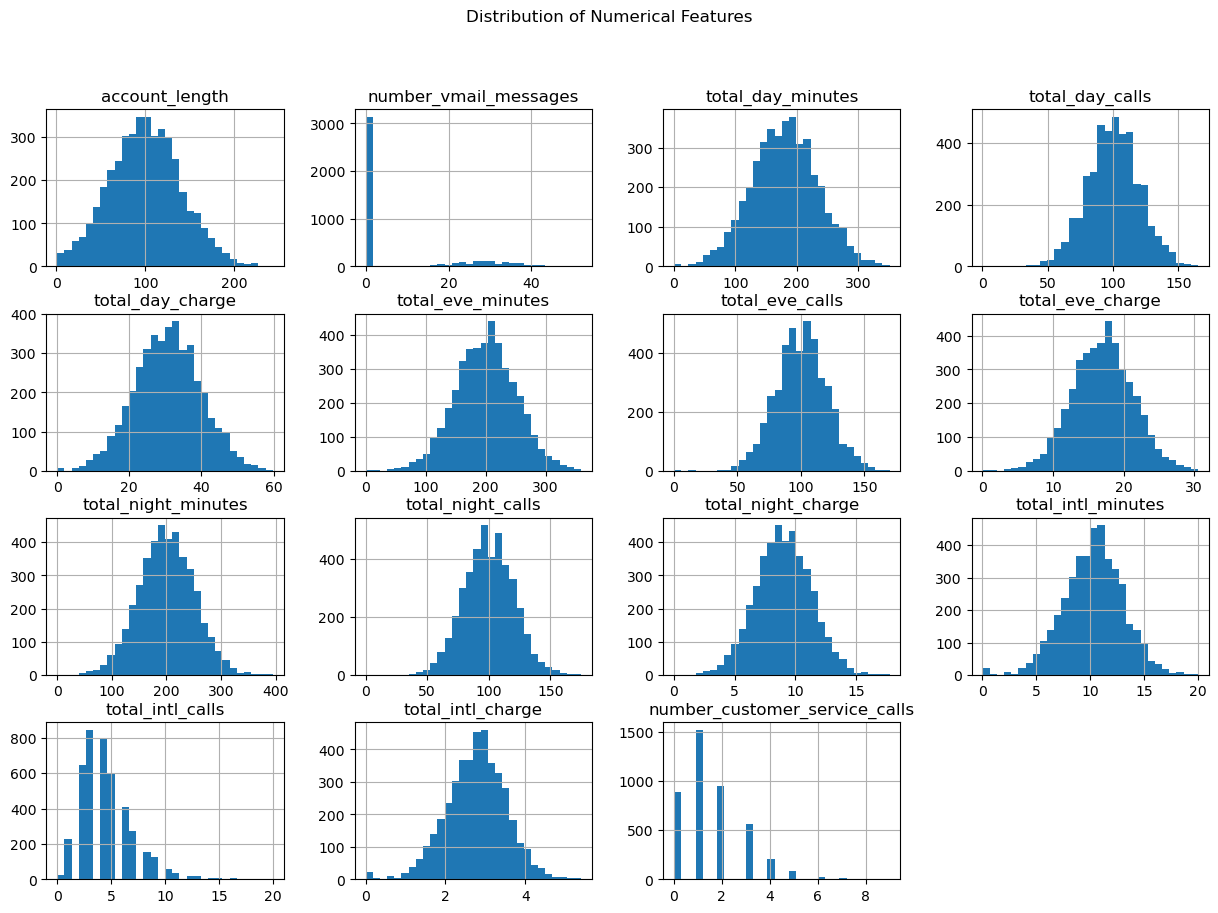

In [18]:
# Visualize the distribution of numerical features
train_data.hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()


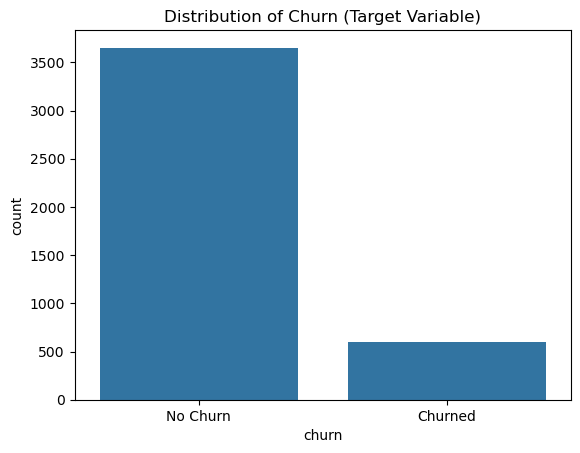

In [20]:
##  Visualizing distribution of churn (target variable) to check for data imbalance 
sns.countplot(x='churn', data=train_data)
plt.title('Distribution of Churn (Target Variable)')

# Modify the x-ticks to show 'No Churn' for 0 and 'Churned' for 1
plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churned'])

plt.show()



In [22]:
print('Class distribution before SMOTE:')
print(train_data['churn'].value_counts())

Class distribution before SMOTE:
churn
no     3652
yes     598
Name: count, dtype: int64


The results of the graph show that their might be imbalance in the data, thus we will apply SMOTE to reduce imbalance and evaluate our models using multiple evaluation metrics to reduce bias

## Feature Engineering

In [24]:
# Create a contingency table for area_code and churn to check relevance of area_code 
contingency_table = pd.crosstab(train_data['area_code'], train_data['churn'])
print(contingency_table)


churn            no  yes
area_code               
area_code_408   934  152
area_code_415  1821  287
area_code_510   897  159


In [26]:
# Calculate churn rates for each area code
contingency_table['churn_rate'] = contingency_table['yes'] / (contingency_table['no'] + contingency_table['yes'])
# Print the table with the churn rates
print(contingency_table[['churn_rate']])


churn          churn_rate
area_code                
area_code_408    0.139963
area_code_415    0.136148
area_code_510    0.150568


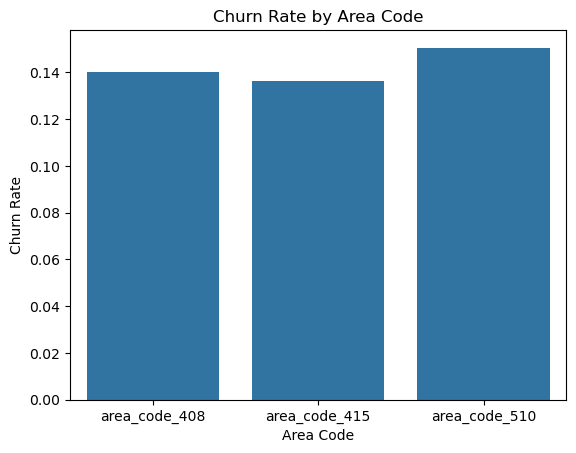

In [30]:
# Plotting churn rate per area code
sns.barplot(x=contingency_table.index, y=contingency_table['churn_rate'])
plt.title('Churn Rate by Area Code')
plt.ylabel('Churn Rate')
plt.xlabel('Area Code')
plt.show()


The churn rate results for each area code are quite similar which indicates this feature may not have a huge significance on the model, thus we will drop it

In [32]:
train_data = train_data.drop(columns=['area_code'])
train_data.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [250]:
test_data = test_data.drop(columns=['area_code'])
test_data.head()


,id,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [34]:
# Handling Categorical data 
def preprocess_data(df, is_training=True):
    # Encode categorical variables
    categorical_columns = ['state', 'international_plan', 'voice_mail_plan']
    for col in categorical_columns:
        df[col] = LabelEncoder().fit_transform(df[col])

    # If it's the training data, encode the target variable
    if is_training:
        df['churn'] = LabelEncoder().fit_transform(df['churn'])
    return df
  

In [36]:
# Preprocess train and test data
train_data = preprocess_data(train_data, is_training=True)
test_data = preprocess_data(test_data, is_training=False)

In [38]:
train_data.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,35,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,31,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,35,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,36,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,19,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In [40]:
test_data.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,16,128,area_code_415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,1,118,area_code_510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,12,62,area_code_415,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,46,93,area_code_510,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,29,174,area_code_415,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [42]:
# Separate features and target variable
X = train_data.drop(columns=['churn'])
y = train_data['churn']


In [44]:
# Split the training data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [46]:
# Initialize SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(y_train_smote.value_counts())

churn
1    2556
0    2556
Name: count, dtype: int64


In [48]:
# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
import joblib
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler as a .pkl file


['scaler.pkl']

## Modeling: Random Forest

In [50]:
# Initialize the Random Forest model
rfc = RandomForestClassifier(random_state=42)

In [52]:
# Fit the model to the training data
rfc.fit(X_train_scaled, y_train_smote)

RandomForestClassifier(random_state=42)

In [54]:
# Predict the labels for the test set
y_pred_rf = rfc.predict(X_test_scaled)
y_pred_proba_rf = rfc.predict_proba(X_test_scaled)[:, 1]  # For AUC-ROC calculation

In [56]:
# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc_roc = roc_auc_score(y_test, y_pred_proba_rf)

In [58]:
print("\nRandom Forest Model Performance:")
print(f"Model Evaluation Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"AUC-ROC: {rf_auc_roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Model Performance:
Model Evaluation Metrics:
Accuracy: 0.9427
Precision: 0.8193
Recall: 0.7598
F1 Score: 0.7884
AUC-ROC: 0.9075

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1096
           1       0.82      0.76      0.79       179

    accuracy                           0.94      1275
   macro avg       0.89      0.87      0.88      1275
weighted avg       0.94      0.94      0.94      1275



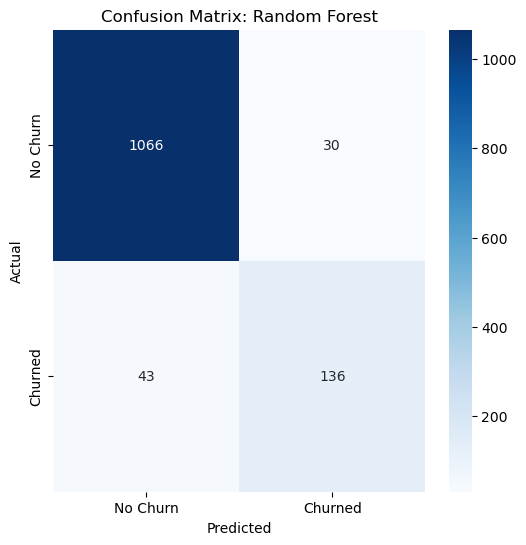

In [60]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churned'], yticklabels=['No Churn', 'Churned'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

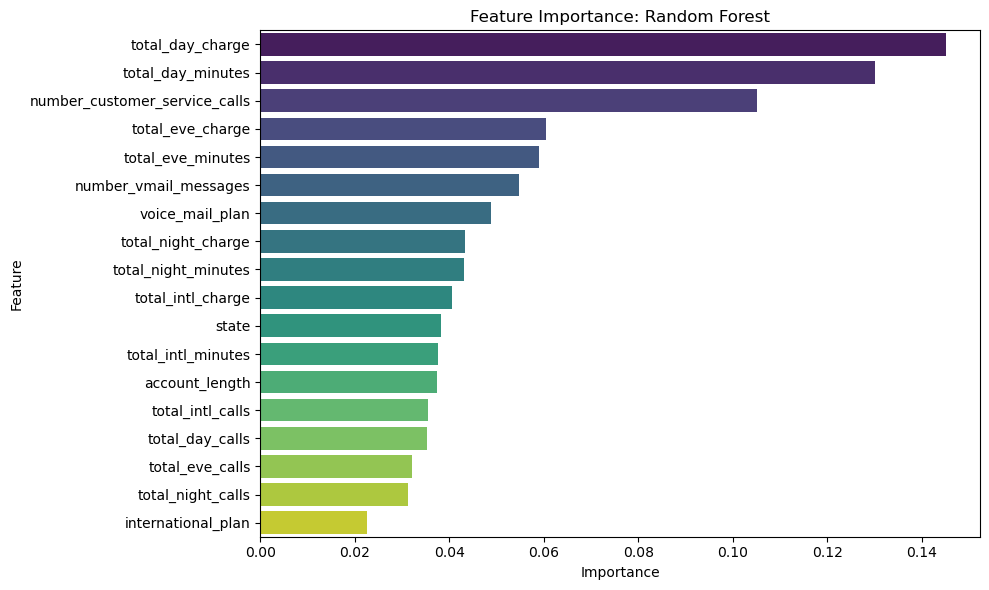

In [94]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,  # Replace X_train.columns with your feature names
    'Importance': rfc.feature_importances_
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.title('Feature Importance: Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Modeling: Gradient Boost

In [62]:
# Initialize the Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier(random_state=42)


In [64]:
gbc_model.fit(X_train_scaled, y_train_smote)

GradientBoostingClassifier(random_state=42)

In [66]:
y_test_pred_gbc = gbc_model.predict(X_test_scaled)
y_test_pred_proba_gbc = gbc_model.predict_proba(X_test_scaled)[:, 1]

In [68]:
gbc_accuracy = accuracy_score(y_test, y_test_pred_gbc)
gbc_precision = precision_score(y_test, y_test_pred_gbc)
gbc_recall = recall_score(y_test, y_test_pred_gbc)
gbc_f1_score = 2 * (gbc_precision * gbc_recall) / (gbc_precision + gbc_recall)
gbc_roc_auc = roc_auc_score(y_test, y_test_pred_proba_gbc)


In [70]:
print("\nGradient Boosting Model Performance:")
print(f"Accuracy: {gbc_accuracy:.2f}")
print(f"Precision: {gbc_precision:.2f}")
print(f"Recall: {gbc_recall:.2f}")
print(f"F1 Score: {gbc_f1_score:.2f}")
print(f"AUC-ROC: {gbc_roc_auc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_gbc))


Gradient Boosting Model Performance:
Accuracy: 0.91
Precision: 0.63
Recall: 0.82
F1 Score: 0.71
AUC-ROC: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      1096
           1       0.63      0.82      0.71       179

    accuracy                           0.91      1275
   macro avg       0.80      0.87      0.83      1275
weighted avg       0.92      0.91      0.91      1275



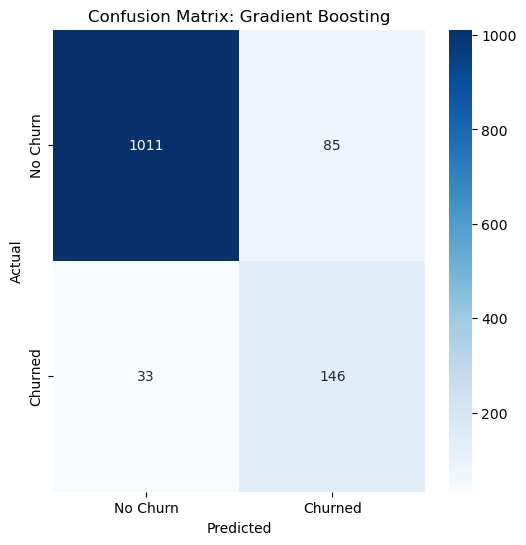

In [72]:
plot_confusion_matrix(y_test, y_test_pred_gbc, "Gradient Boosting")

## Modeling: Support Vector Machines(SVMs)

In [74]:
#support vector machine (svm)
svm_model = SVC(probability=True, random_state=42)


In [76]:
# Define parameter grid for SVM
svm_param_grid = {
    'C': [1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

In [78]:
# Use GridSearchCV to find the best parameters for SVM
svm_grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [80]:
svm_grid_search.fit(X_train_scaled, y_train_smote)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='roc_auc', verbose=1)

In [82]:
# Best parameters and performance for SVM
svm_best_model = svm_grid_search.best_estimator_


In [84]:
# Generate predictions on the validation set
y_val_pred_svm = svm_best_model.predict(X_test_scaled)
y_val_pred_proba_svm = svm_best_model.predict_proba(X_test_scaled)[:, 1]


In [86]:
# Evaluate the SVM model
svm_accuracy = accuracy_score(y_test, y_val_pred_svm)
svm_precision = precision_score(y_test, y_val_pred_svm)
svm_recall = recall_score(y_test, y_val_pred_svm)
svm_f1 = 2 * (svm_precision * svm_recall) / (svm_precision + svm_recall)
svm_roc_auc = roc_auc_score(y_test, y_val_pred_proba_svm)


In [88]:
print("\nSupport Vector Machine Model Performance:")
print(f"Accuracy: {svm_accuracy:.2f}")
print(f"Precision: {svm_precision:.2f}")
print(f"Recall: {svm_recall:.2f}")
print(f"F1 Score: {svm_f1:.2f}")
print(f"AUC-ROC: {svm_roc_auc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_val_pred_svm))




Support Vector Machine Model Performance:
Accuracy: 0.88
Precision: 0.56
Recall: 0.63
F1 Score: 0.59
AUC-ROC: 0.86

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1096
           1       0.56      0.63      0.59       179

    accuracy                           0.88      1275
   macro avg       0.75      0.77      0.76      1275
weighted avg       0.88      0.88      0.88      1275



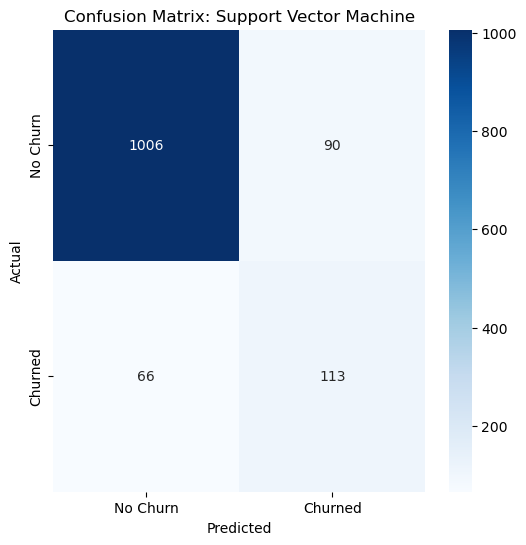

In [90]:
plot_confusion_matrix(y_test, y_val_pred_svm, "Support Vector Machine")

## Modeling: Decision Trees

In [92]:
#Decision Tree 

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)


In [94]:
# Define the parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criteria
    'max_depth': [None, 10, 20],  # Maximum tree depth
    'min_samples_split': [2, 5],  # Minimum samples to split
    'min_samples_leaf': [1, 2]    # Minimum samples at leaf
}

In [96]:
# Use GridSearchCV to find the best parameters for Decision Tree
dt_grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)


In [98]:
# Fit the grid search to the data
dt_grid_search.fit(X_train_scaled, y_train_smote)



Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5]},
             scoring='roc_auc', verbose=1)

In [100]:
dt_best_model = dt_grid_search.best_estimator_


In [102]:
# Generate predictions on the validation set
y_val_pred_dt = dt_best_model.predict(X_test_scaled)
y_val_pred_proba_dt = dt_best_model.predict_proba(X_test_scaled)[:, 1]



In [104]:
# Evaluate the Decision Tree model
dt_accuracy = accuracy_score(y_test, y_val_pred_dt)
dt_precision = precision_score(y_test, y_val_pred_dt)
dt_recall = recall_score(y_test, y_val_pred_dt)
dt_f1 = 2 * (dt_precision * dt_recall) / (dt_precision + dt_recall)
dt_roc_auc = roc_auc_score(y_test, y_val_pred_proba_dt)


In [106]:
print("\nDecision Tree Model Performance:")
print(f"Accuracy: {dt_accuracy:.2f}")
print(f"Precision: {dt_precision:.2f}")
print(f"Recall: {dt_recall:.2f}")
print(f"F1 Score: {dt_f1:.2f}")
print(f"AUC-ROC: {dt_roc_auc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_val_pred_dt))


Decision Tree Model Performance:
Accuracy: 0.87
Precision: 0.53
Recall: 0.74
F1 Score: 0.62
AUC-ROC: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92      1096
           1       0.53      0.74      0.62       179

    accuracy                           0.87      1275
   macro avg       0.74      0.82      0.77      1275
weighted avg       0.89      0.87      0.88      1275



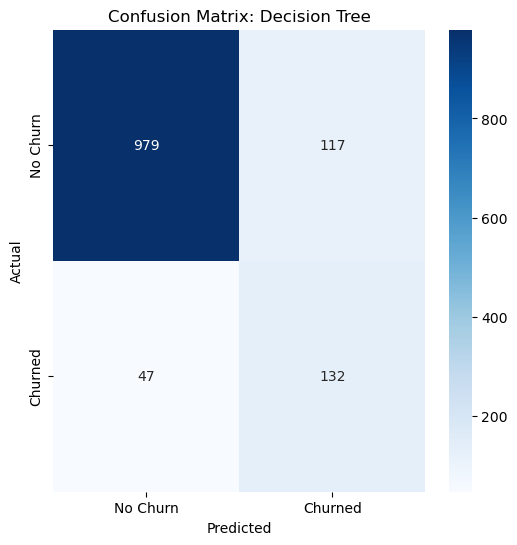

In [108]:
plot_confusion_matrix(y_test, y_val_pred_dt, "Decision Tree")

## Modeling: Logistic Regression

In [110]:
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression


In [112]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)


In [114]:
# Define parameter grid for Logistic Regression
logistic_model.fit(X_train_scaled, y_train_smote)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [116]:
y_test_pred_logistic = logistic_model.predict(X_test_scaled)
y_test_pred_proba_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]


In [118]:
logistic_accuracy = accuracy_score(y_test, y_test_pred_logistic)
logistic_precision = precision_score(y_test, y_test_pred_logistic)
logistic_recall = recall_score(y_test, y_test_pred_logistic)
logistic_f1 = f1_score(y_test, y_test_pred_logistic)
logistic_roc_auc = roc_auc_score(y_test, y_test_pred_proba_logistic)


In [120]:
print("\nLogistic Regression Model Performance:")
print(f"Accuracy: {logistic_accuracy:.2f}")
print(f"Precision: {logistic_precision:.2f}")
print(f"Recall: {logistic_recall:.2f}")
print(f"F1 Score: {logistic_f1:.2f}")
print(f"AUC-ROC: {logistic_roc_auc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_logistic))


Logistic Regression Model Performance:
Accuracy: 0.72
Precision: 0.30
Recall: 0.76
F1 Score: 0.43
AUC-ROC: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.71      0.81      1096
           1       0.30      0.76      0.43       179

    accuracy                           0.72      1275
   macro avg       0.62      0.73      0.62      1275
weighted avg       0.86      0.72      0.76      1275



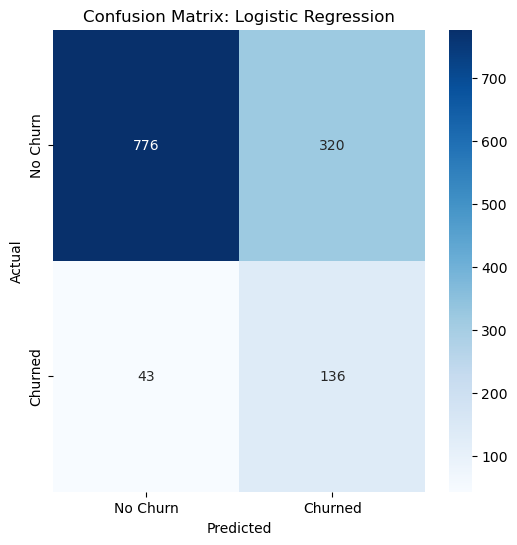

In [122]:
plot_confusion_matrix(y_test, y_test_pred_logistic, "Logistic Regression")

## Modeling: Naive Bayes

In [124]:
#NAIVE BAYES
from sklearn.naive_bayes import GaussianNB


In [126]:
# Initialize the Naive Bayes model
nb_model = GaussianNB()

In [128]:
# Fit the Naive Bayes model to the training data
nb_model.fit(X_train_scaled, y_train_smote)


GaussianNB()

In [130]:
# Generate predictions on the validation set
y_test_pred_nb = nb_model.predict(X_test_scaled)
y_test_pred_proba_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

In [132]:
# Evaluate the Naive Bayes model
nb_accuracy = accuracy_score(y_test, y_test_pred_nb)
nb_precision = precision_score(y_test, y_test_pred_nb)
nb_recall = recall_score(y_test, y_test_pred_nb)
nb_f1 = f1_score(y_test, y_test_pred_nb)
nb_roc_auc = roc_auc_score(y_test, y_test_pred_proba_nb)


In [134]:
print("\nNaive Bayes Model Performance:")
print(f"Accuracy: {nb_accuracy:.2f}")
print(f"Precision: {nb_precision:.2f}")
print(f"Recall: {nb_recall:.2f}")
print(f"F1 Score: {nb_f1:.2f}")
print(f"AUC-ROC: {nb_roc_auc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_nb))


Naive Bayes Model Performance:
Accuracy: 0.63
Precision: 0.25
Recall: 0.80
F1 Score: 0.38
AUC-ROC: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.60      0.74      1096
           1       0.25      0.80      0.38       179

    accuracy                           0.63      1275
   macro avg       0.60      0.70      0.56      1275
weighted avg       0.85      0.63      0.69      1275



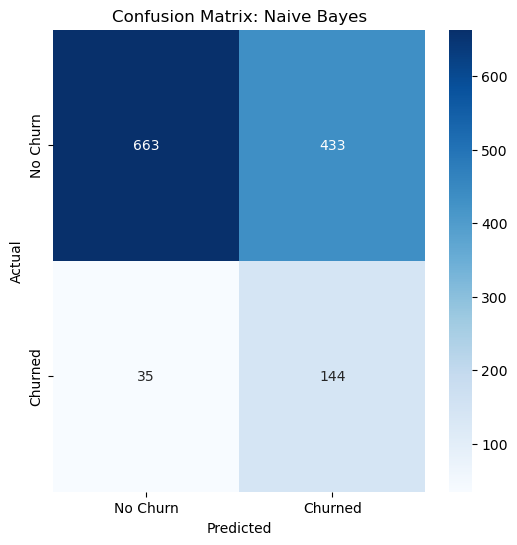

In [136]:
plot_confusion_matrix(y_test, y_test_pred_nb, "Naive Bayes")

## Results Comparision 

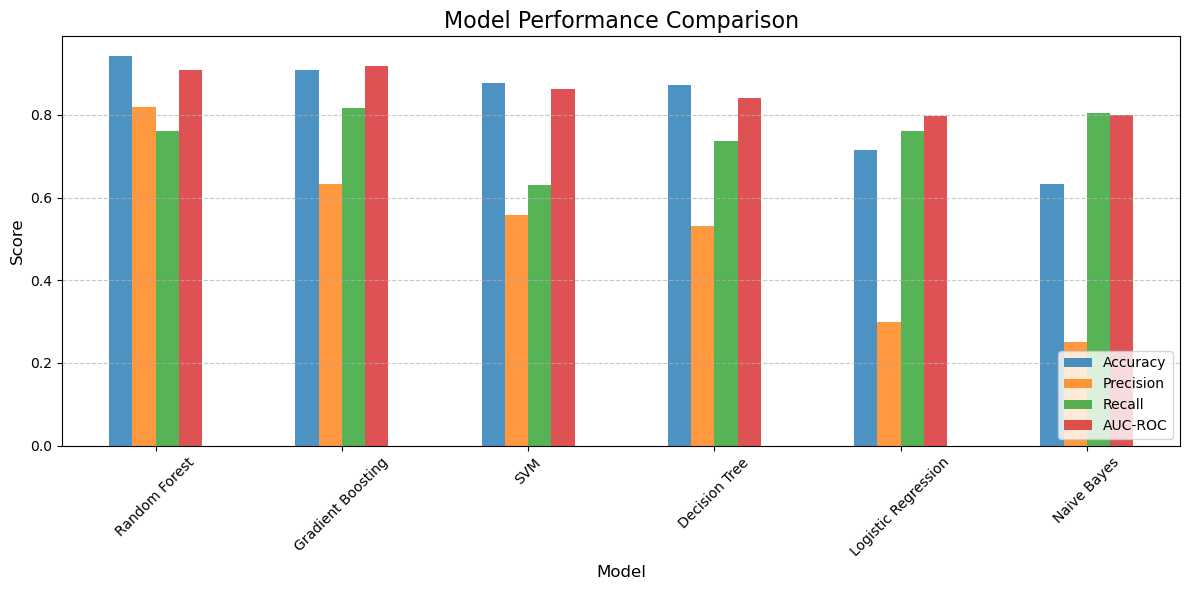

In [138]:
# Create a DataFrame for comparison
metrics = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Logistic Regression', 'Naive Bayes'],
    'Accuracy': [rf_accuracy, gbc_accuracy, svm_accuracy, dt_accuracy, logistic_accuracy, nb_accuracy],
    'Precision': [rf_precision, gbc_precision, svm_precision, dt_precision, logistic_precision, nb_precision],
    'Recall': [rf_recall, gbc_recall, svm_recall, dt_recall, logistic_recall, nb_recall],
    'AUC-ROC': [rf_auc_roc, gbc_roc_auc, svm_roc_auc, dt_roc_auc, logistic_roc_auc, nb_roc_auc]
})

# Plot the comparison
metrics.set_index('Model').plot(kind='bar', figsize=(12, 6), alpha=0.8)
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()  # Adjust layout to fit labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [140]:
import pandas as pd
from IPython.display import display

# Create a DataFrame for evaluation metrics
evaluation_metrics = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Logistic Regression', 'Naive Bayes'],
    'Accuracy': [rf_accuracy, gbc_accuracy, svm_accuracy, dt_accuracy, logistic_accuracy, nb_accuracy],
    'Precision': [rf_precision, gbc_precision, svm_precision, dt_precision, logistic_precision, nb_precision],
    'Recall': [rf_recall, gbc_recall, svm_recall, dt_recall, logistic_recall, nb_recall],
    'F1 Score': [rf_f1, gbc_f1_score, svm_f1, dt_f1, logistic_f1, nb_f1],
    'AUC-ROC': [rf_auc_roc, gbc_roc_auc, svm_roc_auc, dt_roc_auc, logistic_roc_auc, nb_roc_auc]
})

# Format and display the table
display(evaluation_metrics.style.format({
    'Accuracy': '{:.2f}', 
    'Precision': '{:.2f}', 
    'Recall': '{:.2f}', 
    'F1 Score': '{:.2f}', 
    'AUC-ROC': '{:.2f}'
}))


,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Random Forest,0.94,0.82,0.76,0.79,0.91
1,Gradient Boosting,0.91,0.63,0.82,0.71,0.92
2,SVM,0.88,0.56,0.63,0.59,0.86
3,Decision Tree,0.87,0.53,0.74,0.62,0.84
4,Logistic Regression,0.72,0.30,0.76,0.43,0.80
5,Naive Bayes,0.63,0.25,0.80,0.38,0.80


Based on the results, we can conclude that Random forest and Gradient Boosting are the best models due to having highest accuracy, precision,recall, AUC-ROC and F1-score in predicting customer churn.

## Modeling using test.csv data 

In [160]:
test_data.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,16,128,area_code_415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,1,118,area_code_510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,12,62,area_code_415,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,46,93,area_code_510,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,29,174,area_code_415,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [162]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          750 non-null    int32  
 1   account_length                 750 non-null    int64  
 2   area_code                      750 non-null    object 
 3   international_plan             750 non-null    int32  
 4   voice_mail_plan                750 non-null    int32  
 5   number_vmail_messages          750 non-null    int64  
 6   total_day_minutes              750 non-null    float64
 7   total_day_calls                750 non-null    int64  
 8   total_day_charge               750 non-null    float64
 9   total_eve_minutes              750 non-null    float64
 10  total_eve_calls                750 non-null    int64  
 11  total_eve_charge               750 non-null    float64
 12  total_night_minutes            750 non-null    flo

In [164]:
scaler = joblib.load('scaler.pkl')

In [170]:
test_data = test_data.drop(columns=[ 'area_code'])


In [172]:
X_test = test_data
X_test_data_scaled = scaler.transform(X_test)

In [174]:
y_test_pred = rfc.predict(X_test_data_scaled)


In [176]:
test_data['Predicted_Churn'] = y_test_pred


In [178]:
test_data.to_csv('test_predictions.csv', index=False)

In [180]:
test_data.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Predicted_Churn
0,16,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,1,118,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0
2,12,62,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,1
3,46,93,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,0
4,29,174,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,0


In [182]:
test_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          750 non-null    int32  
 1   account_length                 750 non-null    int64  
 2   international_plan             750 non-null    int32  
 3   voice_mail_plan                750 non-null    int32  
 4   number_vmail_messages          750 non-null    int64  
 5   total_day_minutes              750 non-null    float64
 6   total_day_calls                750 non-null    int64  
 7   total_day_charge               750 non-null    float64
 8   total_eve_minutes              750 non-null    float64
 9   total_eve_calls                750 non-null    int64  
 10  total_eve_charge               750 non-null    float64
 11  total_night_minutes            750 non-null    float64
 12  total_night_calls              750 non-null    int

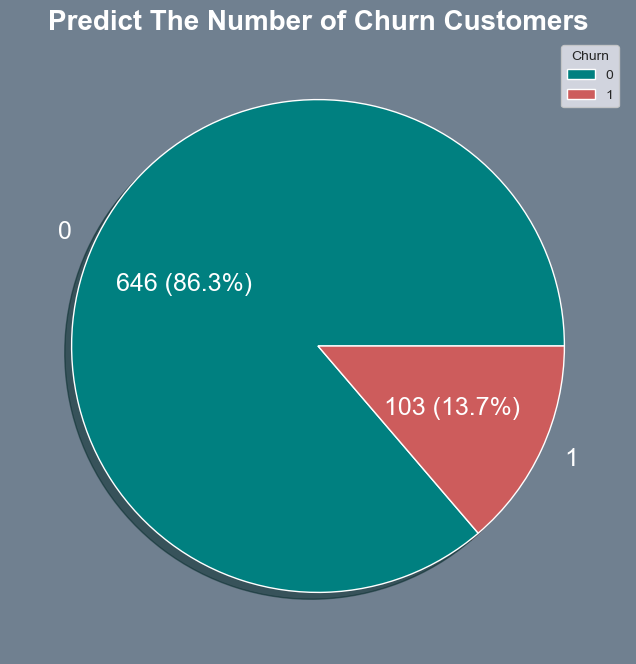

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8), facecolor='slategray')

# Get the value counts of churn prediction
churn = test_data['Predicted_Churn'].value_counts()
colors = ['teal', 'indianred']
# Set seaborn style
sns.set_style('darkgrid')

# Define a function to format the percentage label
def pie_label(pct, values):
    absolute = int(pct / 100.*sum(values))  # Convert percentage to absolute value
    return f"{absolute} ({pct:.1f}%)"

# Create pie chart
plt.pie(churn, labels=churn.index, autopct=lambda pct: pie_label(pct, churn), 
        colors=colors, shadow=True, textprops=dict(color='white', fontsize=18))

# Add title and style it
plt.title("Predict The Number of Churn Customers", color='white', loc='center', weight='bold', fontsize=20)

# Add legend
plt.legend(title='Churn', loc='upper right', fontsize=10)

# Show the plot
plt.show()
